# EEG Mental Arithmetic Tasks Data - Before

MDPI Citation: Zyma I, Tukaev S, Seleznov I, Kiyono K, Popov A, Chernykh M, Shpenkov O. Electroencephalograms during Mental Arithmetic Task Performance. Data. 2019; 4(1):14. https://doi.org/10.3390/data4010014

PhysioNet Citation:
Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

Found on PhysioNet. This contains 36 participants' EEG data. EDF files with _1 suffix contain EEG data before performing tasks and files with _2 suffix contain EEG data during performing tasks. 24 subjects were in good quality count category and 12 subjects were in bad quality category. This data has had artifacts removed during preprocessing.

## Importing and Preprocessing Data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
# For output file path
import os

# Path to the folder containing EEG for Mental Arithmetic Tasks dataset files in Google Drive
edf_folder_path = '/content/drive/MyDrive/eeg-mental-arithmetic/'

In [ ]:
! pip install pyedflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 37.2 MB/s eta 0:00:00


In [ ]:
! pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 6.2 MB/s eta 0:00:00


In [ ]:
! pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 41.4 MB/s eta 0:00:00


In [ ]:
# Import packages
import pandas as pd
import pyedflib # For reading EEG data
import numpy as np
from torch.utils.data import DataLoader, TensorDataset # For dataloader when about to train SNN
import snntorch as snn # SNN package
import torch
# Import MNE packages
import mne # Reading EEG data
import mne.viz # EEG data visualizations
from mne.io import concatenate_raws, read_raw_edf # Reading in raw EDFs
from mne.channels import make_standard_montage # EDF montage

In [ ]:
# Load the labels from the CSV file into a dictionary for matching with edf files
csv_path = '/content/drive/MyDrive/eeg-mental-arithmetic/subject-info.csv'
labels_df = pd.read_csv(csv_path)
# Look at labels for each subject
display(labels_df)

,Subject,Age,Gender,Recording year,Number of subtractions,Count quality
0,Subject00,21,F,2011,9.70,0
1,Subject01,18,F,2011,29.35,1
2,Subject02,19,F,2012,12.88,1
3,Subject03,17,F,2010,31.00,1
4,Subject04,17,F,2010,8.60,0
5,Subject05,16,F,2010,20.71,1
6,Subject06,18,M,2011,4.35,0
7,Subject07,18,F,2012,13.38,1
8,Subject08,26,M,2011,18.24,1
9,Subject09,16,F,2010,7.00,0


In [ ]:
# Import all _1 edf files (before task), manually import files corresponding to each group

# Separate into bad quality count (label 0) and good quality count (label 1)
bad_count_files = ['Subject00_1.edf', 'Subject04_1.edf', 'Subject06_1.edf', 'Subject09_1.edf',
                   'Subject10_1.edf', 'Subject14_1.edf', 'Subject19_1.edf', 'Subject21_1.edf',
                   'Subject22_1.edf', 'Subject30_1.edf'] # 12 bad count quality subjects
good_count_files = ['Subject01_1.edf', 'Subject02_1.edf', 'Subject03_1.edf', 'Subject05_1.edf',
                    'Subject07_1.edf', 'Subject08_1.edf', 'Subject11_1.edf', 'Subject12_1.edf',
                    'Subject13_1.edf', 'Subject15_1.edf', 'Subject16_1.edf', 'Subject17_1.edf',
                    'Subject18_1.edf', 'Subject20_1.edf', 'Subject23_1.edf', 'Subject24_1.edf',
                    'Subject25_1.edf', 'Subject26_1.edf', 'Subject27_1.edf', 'Subject28_1.edf',
                    'Subject29_1.edf', 'Subject31_1.edf', 'Subject32_1.edf', 'Subject33_1.edf',
                    'Subject34_1.edf', 'Subject35_1.edf'] # 24 good count quality subjects

# Initialize lists to store raw objects for bad count and good count quality
raw_good_list = []
raw_bad_list = []

# Function to load edf files into a raw object
def load_edf_files(edf_files, folder_path):
    raw_list = []
    for edf_file in edf_files:
        edf_path = os.path.join(folder_path, edf_file) # Find folder path and edf file

        # Check if the file exists before proceeding
        if not os.path.exists(edf_path):
            print(f"File {edf_file} not found!")
            continue

        # Load the edf file into mne
        try:
            raw = mne.io.read_raw_edf(edf_path, preload=True)
            raw_list.append(raw)  # Append to the list of raw objects
            # Print whether import was successful
            print(f"Successfully loaded {edf_file} with {len(raw.ch_names)} channels.")
        except Exception as e:
            print(f"Error loading {edf_file}: {e}")
    return raw_list

In [ ]:
# Load good and bad count quality files separately using function
raw_good_list = load_edf_files(good_count_files, edf_folder_path)
raw_bad_list = load_edf_files(bad_count_files, edf_folder_path)

# Concatenate raws for good and bad count conditions separately
raw_good = mne.concatenate_raws(raw_good_list) # Raw good count quality object
raw_bad = mne.concatenate_raws(raw_bad_list) # Raw bad count quality object

Extracting EDF parameters from /content/drive/MyDrive/eeg-mental-arithmetic/Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Successfully loaded Subject01_1.edf with 21 channels.
Extracting EDF parameters from /content/drive/MyDrive/eeg-mental-arithmetic/Subject02_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Successfully loaded Subject02_1.edf with 21 channels.
Extracting EDF parameters from /content/drive/MyDrive/eeg-mental-arithmetic/Subject03_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Successfully loaded Subject03_1.edf with 21 channels.
Extracting EDF parameters from /content/drive/MyDrive/eeg-mental-arithmetic/Subject05_1.edf...
EDF file detected
Setting channel info st

In [ ]:
# Set the channel locations and types for both raw objects
for raw in [raw_good, raw_bad]:
    raw.rename_channels({'EEG Fp1':'Fp1','EEG Fp2':'Fp2','EEG F3':'F3','EEG F4':'F4','EEG F7':'F7','EEG F8':'F8',
                         'EEG T3':'T3','EEG T4':'T4','EEG C3':'C3','EEG C4':'C4','EEG T5':'T5','EEG T6':'T6','EEG P3':'P3',
                         'EEG P4':'P4','EEG O1':'O1','EEG O2':'O2','EEG Fz':'Fz','EEG Cz':'Cz','EEG Pz':'Pz',
                         'EEG A2-A1':'A2','ECG ECG':'ECG'})
    raw.set_channel_types({'ECG': 'ecg'})
    raw.set_montage(mne.channels.make_standard_montage('standard_1020'))  # Set montage

In [ ]:
# Get data from raw good count object
raw_data_1 = raw_good.get_data()
print("Number of channels: ", str(len(raw_data_1))) # print channels
print("Number of samples: ", str(len(raw_data_1[0]))) # print samples
# Get Sampling Frequency
fs_g=raw_good.info['sfreq']
print("Sampling Frequency: ", str(fs_g))# Get data from raw task object

Number of channels:  21
Number of samples:  2315000
Sampling Frequency:  500.0


In [ ]:
# Get data from raw bad count object
raw_data_2 = raw_bad.get_data()
print("Number of channels: ", str(len(raw_data_2))) # print channels
print("Number of samples: ", str(len(raw_data_2[0]))) # print samples
# Get Sampling Frequency
fs_b=raw_bad.info['sfreq']
print("Sampling Frequency: ", str(fs_b))

Number of channels:  21
Number of samples:  907000
Sampling Frequency:  500.0


## Visualizing Good vs. Bad Count Quality

In [ ]:
# Import more packages
%matplotlib inline
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import copy

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


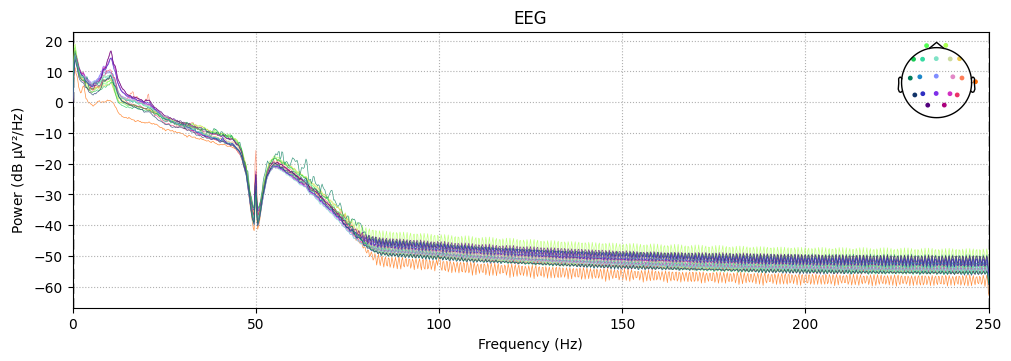

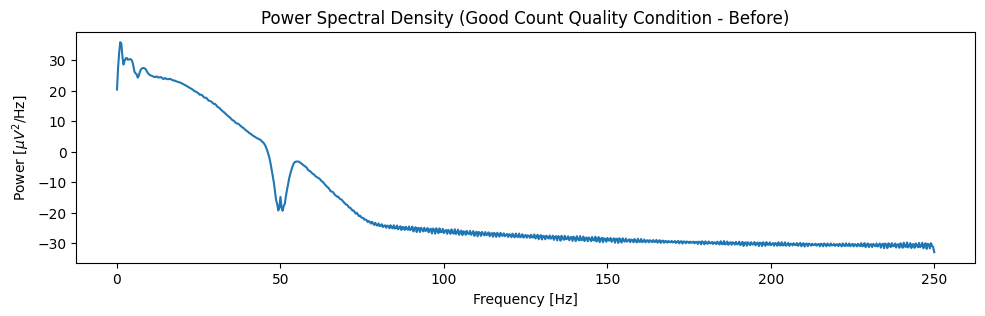

In [ ]:
# Plot_psd function for plotting raw good count object Power Spectral Density (PSD)
raw_good.plot_psd()
# Alternative scipy plot with one line instead of multiple channels
f, Sxx = sp.signal.welch(raw_good._data[20,:], fs=fs_g, window=('hann'),
nperseg=1500, noverlap=1000, scaling='density')
# The scale of Sxx use scaling='density' is V**2/Hz
# To change the scale to muV**2/Hz(Db) which mne uses, use the following conversion
plt.figure(figsize=(11.6,3))
plt.plot(f, 10*np.log10(Sxx*1e6**2))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power [$\mu V^2$/Hz]')
plt.title('Power Spectral Density (Good Count Quality Condition - Before)')
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


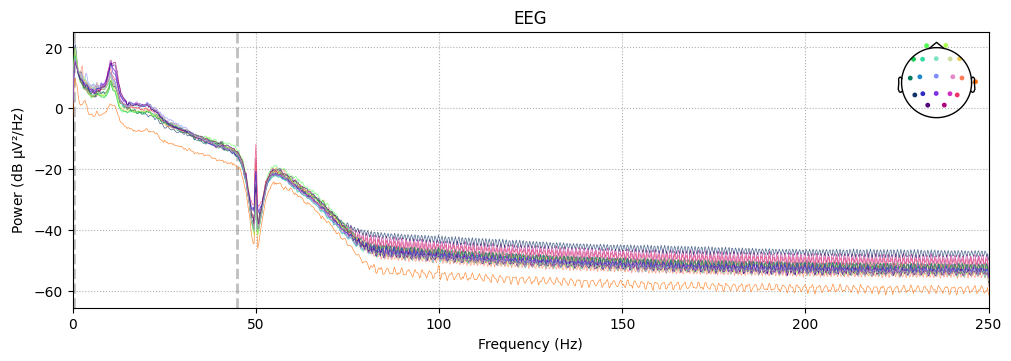

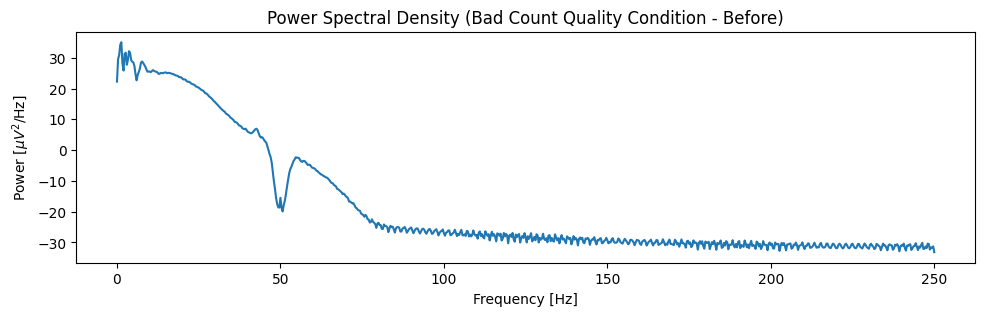

In [ ]:
# Plot_psd function for plotting raw bad count object Power Spectral Density (PSD)
raw_bad.plot_psd()
# Alternative scipy plot with one line instead of multiple channels
f, Sxx = sp.signal.welch(raw_bad._data[20,:], fs=fs_b, window=('hann'),
nperseg=1500, noverlap=1000, scaling='density')
# The scale of Sxx use scaling='density' is V**2/Hz
# To change the scale to muV**2/Hz(Db) which mne uses, use the following conversion
plt.figure(figsize=(11.6,3))
plt.plot(f, 10*np.log10(Sxx*1e6**2))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power [$\mu V^2$/Hz]')
plt.title('Power Spectral Density (Bad Count Quality Condition - Before)')
plt.show()

In [ ]:
# Check how many seconds are in good data to determine time windows for topomap
total_duration_seconds = raw_good.times[-1]
print(f'Total duration: {total_duration_seconds} seconds')

Total duration: 4629.998 seconds


In [ ]:
# Check how many seconds are in bad data to determine time windows for topomap
total_duration_seconds = raw_bad.times[-1]
print(f'Total duration: {total_duration_seconds} seconds')

Total duration: 1813.998 seconds


<ipython-input-18-4a6639eabade>:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar


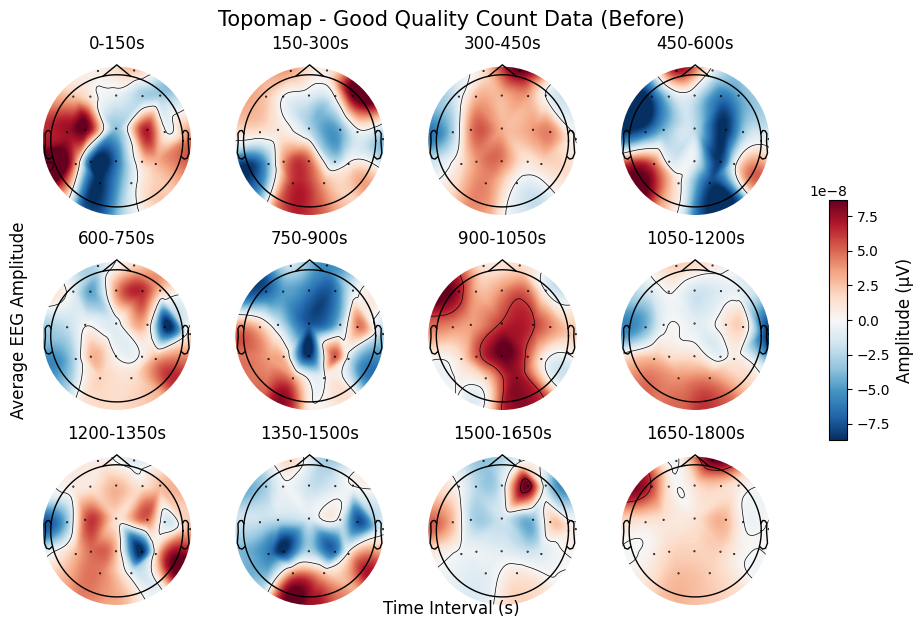

In [ ]:
# Define time intervals in seconds
time_intervals = [(0, 150), (150, 300), (300, 450), (450, 600), (600, 750), (750, 900),
 (900, 1050), (1050, 1200), (1200, 1350), (1350, 1500), (1500, 1650), (1650, 1800)]

# Create a 3-row x 4-column subplot grid for 12 time windows
fig, axes = plt.subplots(3, 4, figsize=(9, 6))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Create colorbar (for shared colorbar)
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # [left, bottom, width, height] placement

# Iterate over the time intervals and plot the topomaps
for i, (start, end) in enumerate(time_intervals):
    # Extract the data for the current time interval
    start_sample = int(start * raw_good.info['sfreq'])  # Convert time to samples
    end_sample = int(end * raw_good.info['sfreq'])  # Convert time to samples
    interval_data = raw_good.get_data(picks='eeg', start=start_sample, stop=end_sample)  # Select 'eeg' channels

    # Compute the average signal over the interval
    avg_data = np.mean(interval_data, axis=1)  # Mean across time points for each channel

    # Plot the topomap for the current time interval in the corresponding subplot
    im, _ = mne.viz.plot_topomap(
        avg_data,
        pos=raw_good.info,
        ch_type='eeg',
        axes=axes[i],
        show=False,
        contours=1  # Show contours
    )
    axes[i].set_title(f'{start}-{end}s')  # Add topomap label for time window

# Add colorbar
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Amplitude (μV)', fontsize=12)

# Add axis labels and title to entire figure
fig.text(0.5, 0.01, 'Time Interval (s)', ha='center', fontsize=12)
fig.text(0.01, 0.5, 'Average EEG Amplitude', va='center', rotation='vertical', fontsize=12)
fig.text(0.5, 0.99, 'Topomap - Good Quality Count Data (Before)', ha='center', fontsize=15)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar
plt.show()

<ipython-input-19-281d6dcf6fe7>:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


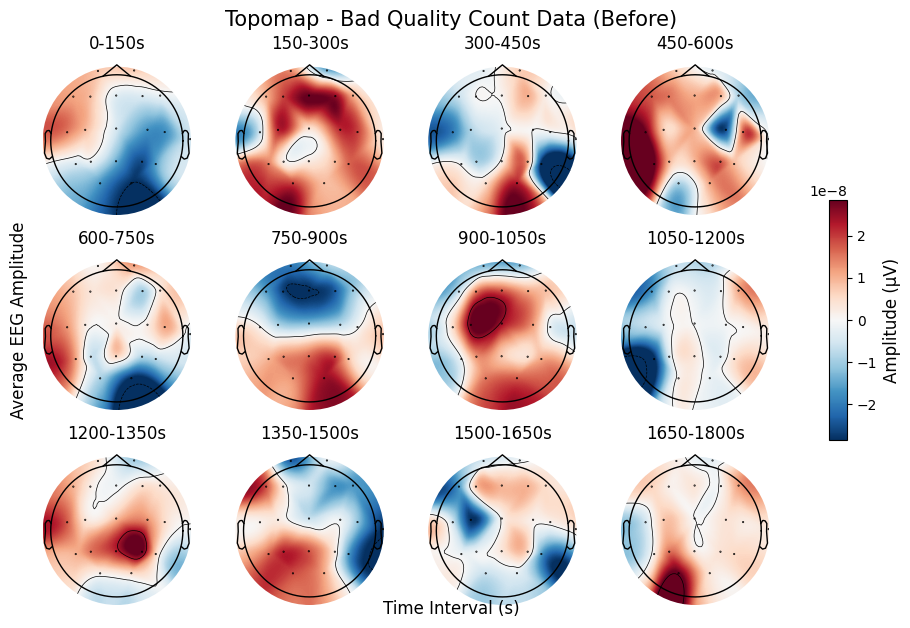

In [ ]:
# Define time intervals in seconds
time_intervals = [(0, 150), (150, 300), (300, 450), (450, 600), (600, 750), (750, 900),
 (900, 1050), (1050, 1200), (1200, 1350), (1350, 1500), (1500, 1650), (1650, 1800)]

# Create a 3-row x 4-column subplot grid for 12 time windows
fig, axes = plt.subplots(3, 4, figsize=(9, 6))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Create common colorbar axis
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # [left, bottom, width, height]

# Iterate over the time intervals and plot the topomaps
for i, (start, end) in enumerate(time_intervals):
    # Extract the data for the current time interval
    start_sample = int(start * raw_bad.info['sfreq'])  # Convert time to samples
    end_sample = int(end * raw_bad.info['sfreq'])  # Convert time to samples
    interval_data = raw_bad.get_data(picks='eeg', start=start_sample, stop=end_sample)  # Select 'eeg' channels

    # Compute the average signal over the interval
    avg_data = np.mean(interval_data, axis=1)  # Mean across time points for each channel

    # Plot the topomap for the current time interval in the corresponding subplot
    im, _ = mne.viz.plot_topomap(
        avg_data,
        pos=raw_bad.info,
        ch_type='eeg',
        axes=axes[i],
        show=False,
        contours=1  # Show contours
    )
    axes[i].set_title(f'{start}-{end}s')  # Add topomap label for time window

# Add colorbar
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Amplitude (μV)', fontsize=12)

# Add axis labels and title to entire figure
fig.text(0.5, 0.01, 'Time Interval (s)', ha='center', fontsize=12)
fig.text(0.01, 0.5, 'Average EEG Amplitude', va='center', rotation='vertical', fontsize=12)
fig.text(0.5, 0.99, 'Topomap - Bad Quality Count Data (Before)', ha='center', fontsize=15)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
plt.show()

Filtering raw data in 26 contiguous segments
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


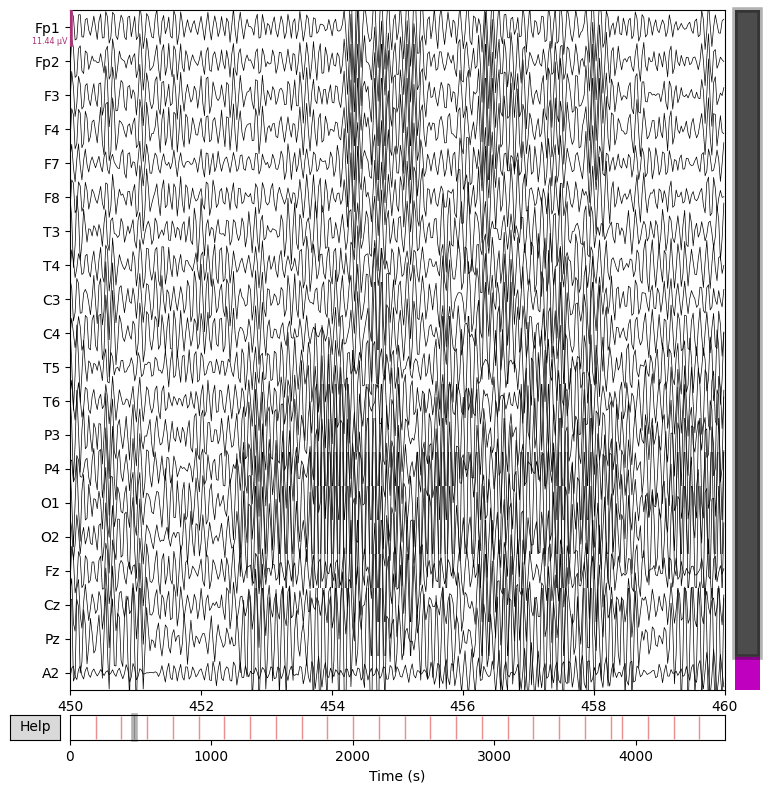

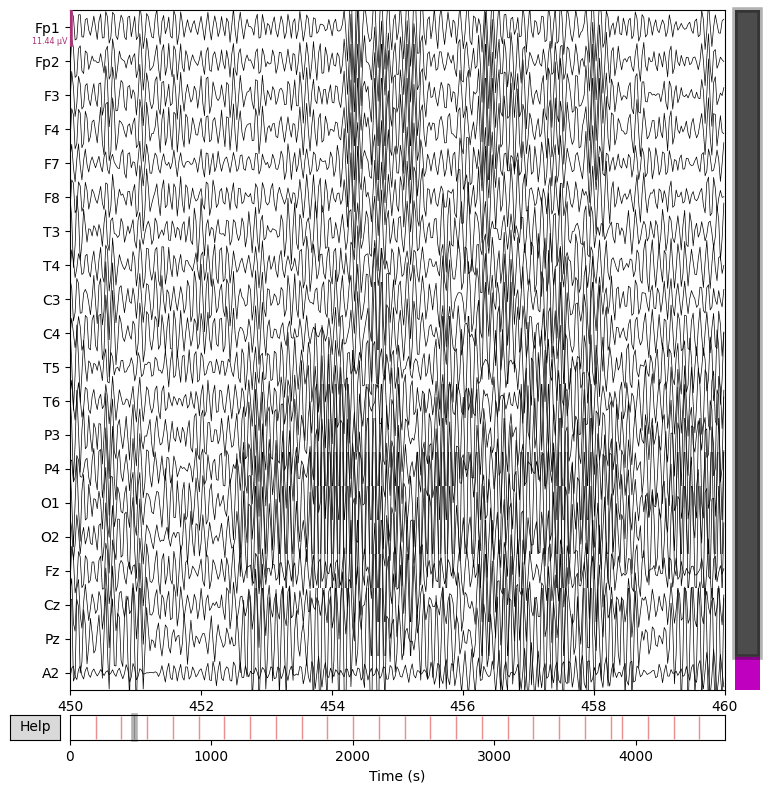

In [ ]:
# Plot the time-domain signal for raw_good between alpha band (common duing consciousness)
raw_good.filter(8., 12.) # Filter between alpha band (8-12 Hz)
# Plot the time-domain signal within time window
raw_good.plot(scalings='auto', title='Time-Domain Signal: Good Count Quality EEG (Before)',
                    start=450,  # Start time in seconds
                    duration=10, # Duration of time window
                    show=True)

Filtering raw data in 10 contiguous segments
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


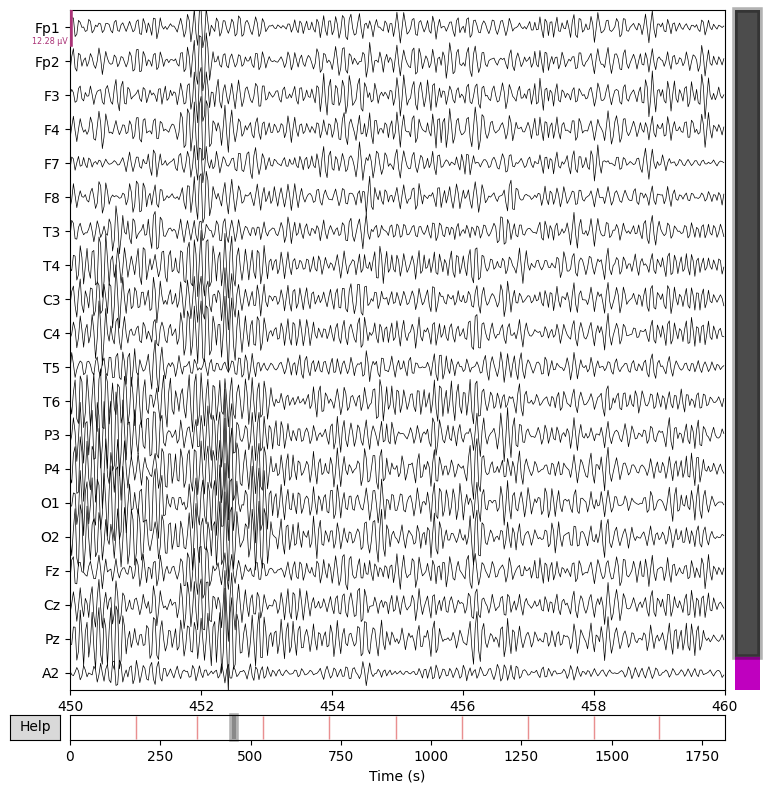

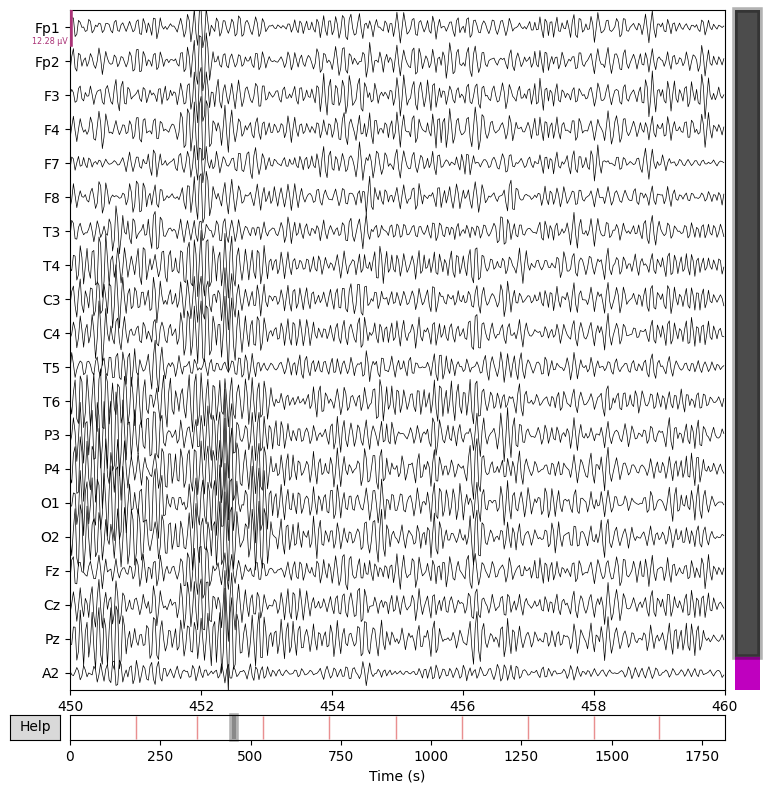

In [ ]:
# Plot the time-domain signal for raw_bad between alpha band (common during consciousness)
raw_bad.filter(8., 12.) # Filter between alpha band (8-12 Hz)
# Plot the time-domain signal within time window
raw_bad.plot(scalings='auto', title='Time-Domain Signal: Bad Count Quality EEG (Before)',
                    start=450,  # Start time in seconds
                    duration=10, # Duration of time window
                    show=True)

## SNN

In [ ]:
# Extract data and sampling frequency from the raw good and bad count quality objects
data_good, _ = raw_good[:, :]
data_bad, _ = raw_bad[:, :]
fs_g = int(raw_good.info['sfreq'])
fs_b = int(raw_bad.info['sfreq'])
print(fs_g, fs_b) # Print sampling frequencies of the raw objects

500 500


In [ ]:
# Set segment size to 1000 sample data points for splitting (larger samples due to more before task data)
window_size = 1000

# Segment the data into non-overlapping windows
def segment_data(data, window_size):
    num_segments = data.shape[1] // window_size # Split into 1000-sample point segments
    segments = np.array_split(data[:, :num_segments * window_size], num_segments, axis=1) # Convert into numpy array
    return segments

In [ ]:
# Segment the good and bad data
segments_good = segment_data(data_good, window_size)
segments_bad = segment_data(data_bad, window_size)

# Label the segments as 1 for good, 0 for bad as in csv
labels_good = np.ones(len(segments_good))
labels_bad = np.zeros(len(segments_bad))

In [ ]:
# Combine the segments and labels into numpy dataset
segments = np.array(segments_good + segments_bad)  # All segmented data
labels = np.concatenate([labels_good, labels_bad])  # All label data

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score # Evaluation metrics

In [ ]:
# Print shape of all segments and labels
print(np.shape(segments))
print(np.shape(labels))
# Change dimension of data for ML Algorithm
X_all=np.mean(segments,axis=1)
Y_all=labels
X_all=sp.stats.zscore(X_all,axis=1)
print(np.shape(X_all))
print(np.shape(Y_all))
# Set to X and Y for training
X=X_all
Y=Y_all
print(np.shape(X))
print(np.shape(Y))
# Check for NaN values in X and Y
print(np.isnan(X).any())
print(np.isnan(Y).any())

(3222, 21, 1000)
(3222,)
(3222, 1000)
(3222,)
(3222, 1000)
(3222,)
False
False


In [ ]:
# Since there are NaN values in X (sometimes there are no NaN values), impute using SimpleImputer
from sklearn.impute import SimpleImputer

# Handle NaN values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Replace NaNs with the mean of each column
X = imputer.fit_transform(X) # Set X to newly imputed missing values

In [ ]:
# Take counts of Y to see imbalance of labels
unique, counts = np.unique(Y, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 907, 1.0: 2315}


In [ ]:
# Confirm shape of X and Y again
print(X.shape)
print(Y.shape)

(3222, 1000)
(3222,)


In [ ]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets - 70% training and 30% testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Check shapes
print("Training set shape:", X_train.shape, Y_train.shape)
print("Testing set shape:", X_test.shape, Y_test.shape)

Training set shape: (2255, 1000) (2255,)
Testing set shape: (967, 1000) (967,)


In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
Y_train_tensor = torch.LongTensor(Y_train)
X_test_tensor = torch.FloatTensor(X_test)
Y_test_tensor = torch.LongTensor(Y_test)

# Create TensorDataset objects for training and testing
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# Define DataLoader batch size
batch_size = 32

# Create DataLoaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check if DataLoader works correctly by iterating over a batch
for X_batch, Y_batch in train_loader:
    print("X_batch shape:", X_batch.shape)
    print("Y_batch shape:", Y_batch.shape)
    break  # Stop showing after 1 batch

X_batch shape: torch.Size([32, 1000])
Y_batch shape: torch.Size([32])


In [ ]:
# Import torch.nn
import torch.nn as nn

In [ ]:
# Define the SNN model architecture
class SNNModel(nn.Module):
    def __init__(self, input_size):
        super(SNNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)  # Fully connected layer with 100 neurons
        self.lif1 = snn.Leaky(beta=0.9)  # LIF neuron with snn.Leaky to handle spikes
        self.fc2 = nn.Linear(100, 2)  # Output layer for binary classification

    def forward(self, x):
        # Pass through the first fully connected layer
        x = self.fc1(x)

        # Process with the LIF layer and generate spikes
        mem, spikes = self.lif1(x)

        # Pass through the second fully connected layer
        output = self.fc2(spikes)

        return output

In [ ]:
# Initialize network, optimizer, and loss function
input_size = X_train.shape[1]
model = SNNModel(input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0  # Track loss for each epoch

    # Iterate over batches from the training loader
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        output = model(X_batch)
        loss = criterion(output, Y_batch)

        # Backward pass and optimization
        loss.backward(retain_graph=True)
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)  # Accumulate loss

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)

    # Print training loss every epoch
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}')

    # Evaluation on test data
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            outputs = model(X_batch) # evaluates based on batch in X
            _, predicted = torch.max(outputs.data, 1) # takes maximum score

            all_preds.extend(predicted.cpu().numpy()) # appends to all_preds
            all_labels.extend(Y_batch.cpu().numpy()) # appends to all_labels

    # Calculate Accuracy, Balanced Accuracy, and F1-Score
    accuracy = accuracy_score(all_labels, all_preds)
    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')  # 'weighted' accounts for class imbalance

    # Print evaluation metrics
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Accuracy: {accuracy*100:.2f}%')
    print(f'Epoch [{epoch + 1}/{num_epochs}], Balanced Accuracy: {balanced_accuracy:.2f}')
    print(f'Epoch [{epoch + 1}/{num_epochs}], F1-Score: {f1:.2f}')

Epoch [1/50], Training Loss: 0.8158
Epoch [1/50], Test Accuracy: 59.98%
Epoch [1/50], Balanced Accuracy: 0.50
Epoch [1/50], F1-Score: 0.60
Epoch [2/50], Training Loss: 0.6292
Epoch [2/50], Test Accuracy: 67.32%
Epoch [2/50], Balanced Accuracy: 0.50
Epoch [2/50], F1-Score: 0.62
Epoch [3/50], Training Loss: 0.6242
Epoch [3/50], Test Accuracy: 68.98%
Epoch [3/50], Balanced Accuracy: 0.51
Epoch [3/50], F1-Score: 0.63
Epoch [4/50], Training Loss: 0.6237
Epoch [4/50], Test Accuracy: 69.29%
Epoch [4/50], Balanced Accuracy: 0.49
Epoch [4/50], F1-Score: 0.60
Epoch [5/50], Training Loss: 0.6185
Epoch [5/50], Test Accuracy: 66.29%
Epoch [5/50], Balanced Accuracy: 0.49
Epoch [5/50], F1-Score: 0.60
Epoch [6/50], Training Loss: 0.6171
Epoch [6/50], Test Accuracy: 68.87%
Epoch [6/50], Balanced Accuracy: 0.50
Epoch [6/50], F1-Score: 0.62
Epoch [7/50], Training Loss: 0.6190
Epoch [7/50], Test Accuracy: 69.39%
Epoch [7/50], Balanced Accuracy: 0.50
Epoch [7/50], F1-Score: 0.61
Epoch [8/50], Training Loss